# 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# 2

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 44069651.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 3

In [ ]:
class NetStandard(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NetStandard, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 5, padding=2)
        self.conv2 = nn.Conv2d(96, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.pool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc3(x)
        return x

class NetGrowth(nn.Module):
    def __init__(self, dropout_start=0.1, dropout_end=0.5, total_epochs=50):
        super(NetGrowth, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 5, padding=2)
        self.conv2 = nn.Conv2d(96, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.pool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)
        self.dropout_start = dropout_start
        self.dropout_end = dropout_end
        self.total_epochs = total_epochs

    def forward(self, x, epoch):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dynamic_dropout(x, epoch)
        x = F.relu(self.fc2(x))
        x = self.dynamic_dropout(x, epoch)
        x = self.fc3(x)
        return x

    def dynamic_dropout(self, x, epoch):
        p = self.get_dropout_rate(epoch)
        return F.dropout(x, p=p, training=self.training)

    def get_dropout_rate(self, epoch):
        return self.dropout_start + (self.dropout_end - self.dropout_start) * (epoch / self.total_epochs)



# 4

Epoch 1, Loss: 1.727625626564026, Train Error: 0.44466000000000006, Test Error: 0.45199999999999996
Epoch 2, Loss: 1.1016646978855134, Train Error: 0.28613999999999995, Test Error: 0.30710000000000004
Epoch 3, Loss: 0.8400084911584854, Train Error: 0.23243999999999998, Test Error: 0.2711
Epoch 4, Loss: 0.6815259626507759, Train Error: 0.18710000000000004, Test Error: 0.24580000000000002
Epoch 5, Loss: 0.5770061007738113, Train Error: 0.14156000000000002, Test Error: 0.22540000000000004
Epoch 6, Loss: 0.47952035573124885, Train Error: 0.12217999999999996, Test Error: 0.22030000000000005
Epoch 7, Loss: 0.3985621577501297, Train Error: 0.09004000000000001, Test Error: 0.20909999999999995
Epoch 8, Loss: 0.3377916024923325, Train Error: 0.08086000000000004, Test Error: 0.21130000000000004
Epoch 9, Loss: 0.2854313079342246, Train Error: 0.05276000000000003, Test Error: 0.20479999999999998
Epoch 10, Loss: 0.2312765979617834, Train Error: 0.05035999999999996, Test Error: 0.20650000000000002
Ep

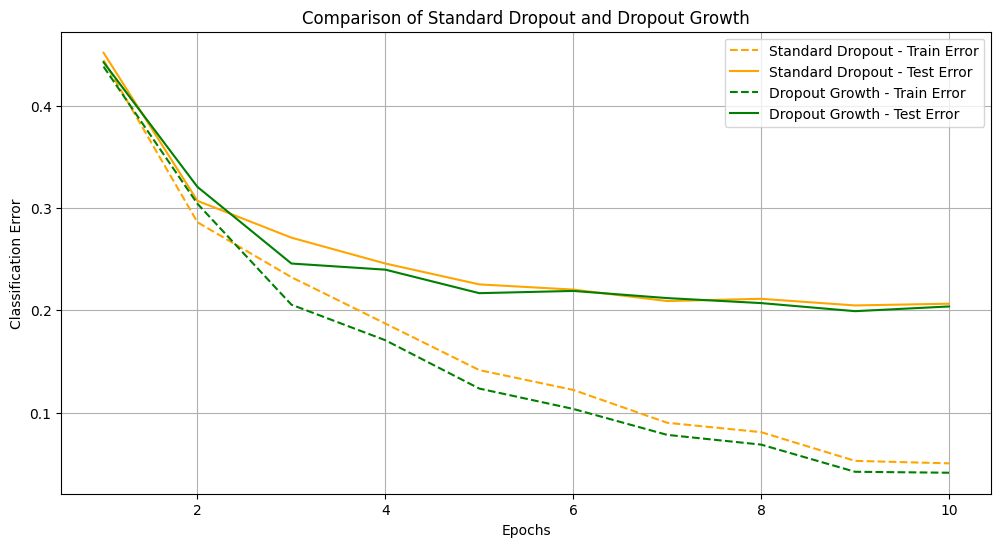

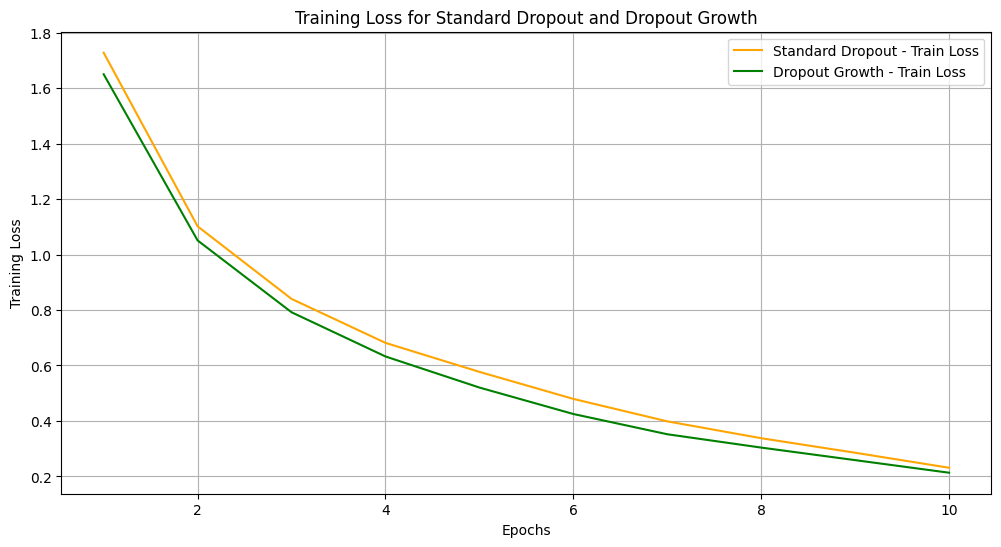

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your models here (NetStandard and NetGrowth)

def train_and_record_errors(net, trainloader, testloader, criterion, optimizer, num_epochs=10, growth=False):
    net.to(device)
    train_errors = []
    test_errors = []
    train_losses = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if growth:
                outputs = net(inputs, epoch)
            else:
                outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate train and test error
        train_error = calculate_classification_error(net, trainloader, epoch, growth)
        test_error = calculate_classification_error(net, testloader, epoch, growth)

        train_errors.append(train_error)
        test_errors.append(test_error)
        train_losses.append(running_loss / len(trainloader))

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Train Error: {train_error}, Test Error: {test_error}')

    return train_errors, test_errors, train_losses

def calculate_classification_error(net, dataloader, epoch, growth):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            if growth:
                outputs = net(images, epoch)
            else:
                outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    error = 1 - (correct / total)
    return error

# Instantiate and train the models
net_standard = NetStandard(dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.SGD(net_standard.parameters(), lr=0.01, momentum=0.95)
train_errors_standard, test_errors_standard, train_losses_standard = train_and_record_errors(net_standard, trainloader, testloader, criterion, optimizer_standard, num_epochs=10, growth=False)

net_growth = NetGrowth(dropout_start=0.1, dropout_end=0.5, total_epochs=10).to(device)
optimizer_growth = optim.SGD(net_growth.parameters(), lr=0.01, momentum=0.95)
train_errors_growth, test_errors_growth, train_losses_growth = train_and_record_errors(net_growth, trainloader, testloader, criterion, optimizer_growth, num_epochs=10, growth=True)

epochs = range(1, 11)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_errors_standard, label='Standard Dropout - Train Error', linestyle='--', color='orange')
plt.plot(epochs, test_errors_standard, label='Standard Dropout - Test Error', color='orange')
plt.plot(epochs, train_errors_growth, label='Dropout Growth - Train Error', linestyle='--', color='green')
plt.plot(epochs, test_errors_growth, label='Dropout Growth - Test Error', color='green')

plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Dropout Growth')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses_standard, label='Standard Dropout - Train Loss', color='orange')
plt.plot(epochs, train_losses_growth, label='Dropout Growth - Train Loss', color='green')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss for Standard Dropout and Dropout Growth')
plt.legend()
plt.grid(True)
plt.show()


# 5

In [ ]:
# Instantiate and train the models
net_standard = NetStandard(dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.SGD(net_standard.parameters(), lr=0.01, momentum=0.95)
train_errors_standard, test_errors_standard = train_and_record_errors(net_standard, trainloader, testloader, criterion, optimizer_standard, num_epochs=10, growth=False)

net_growth = NetGrowth(dropout_start=0.1, dropout_end=0.5, total_epochs=10).to(device)
optimizer_growth = optim.SGD(net_growth.parameters(), lr=0.01, momentum=0.95)
train_errors_growth, test_errors_growth = train_and_record_errors(net_growth, trainloader, testloader, criterion, optimizer_growth, num_epochs=10, growth=True)

Epoch 1, Loss: 2.2849310488700865, Train Error: 0.7842, Test Error: 0.7837000000000001
Epoch 2, Loss: 2.0287415144443512, Train Error: 0.69424, Test Error: 0.6865
Epoch 3, Loss: 1.7865569734573363, Train Error: 0.62338, Test Error: 0.6227
Epoch 4, Loss: 1.6500412290096282, Train Error: 0.5848800000000001, Test Error: 0.5832999999999999
Epoch 5, Loss: 1.5512026679515838, Train Error: 0.5366, Test Error: 0.5405
Epoch 6, Loss: 1.4552753043174744, Train Error: 0.49888, Test Error: 0.5013000000000001
Epoch 7, Loss: 1.3679739882946014, Train Error: 0.47230000000000005, Test Error: 0.47809999999999997
Epoch 8, Loss: 1.292694336414337, Train Error: 0.45194, Test Error: 0.46220000000000006
Epoch 9, Loss: 1.2188485310077668, Train Error: 0.41618, Test Error: 0.42010000000000003
Epoch 10, Loss: 1.1610604199171066, Train Error: 0.3913, Test Error: 0.4001
Epoch 1, Loss: 2.2714819688796997, Train Error: 0.7891, Test Error: 0.7852
Epoch 2, Loss: 1.945557605266571, Train Error: 0.6594800000000001, Tes

# 6

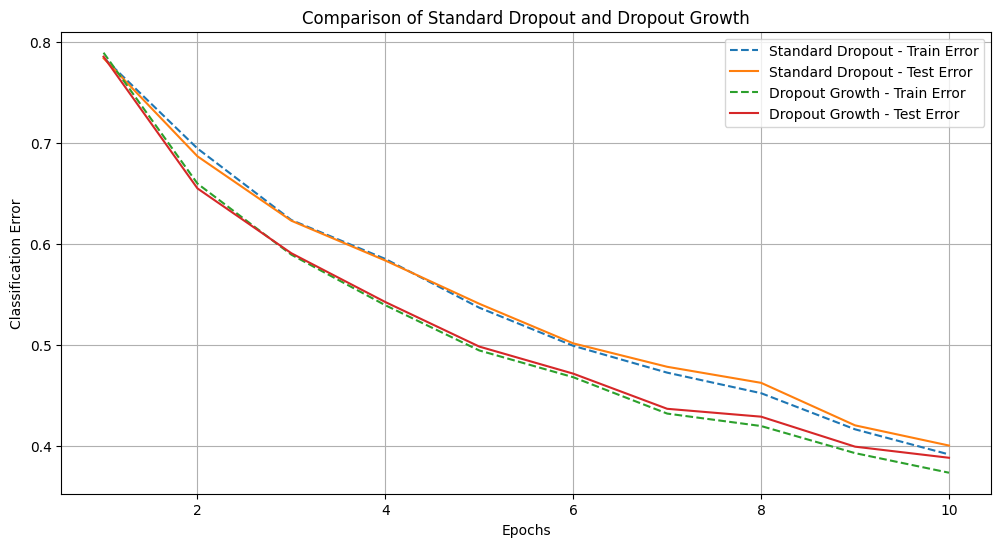

In [ ]:
epochs = range(1, 11)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_errors_standard, label='Standard Dropout - Train Error', linestyle='--')
plt.plot(epochs, test_errors_standard, label='Standard Dropout - Test Error')
plt.plot(epochs, train_errors_growth, label='Dropout Growth - Train Error', linestyle='--')
plt.plot(epochs, test_errors_growth, label='Dropout Growth - Test Error')

plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Dropout Growth')
plt.legend()
plt.grid(True)
plt.show()
